In [58]:
import tensorflow.keras
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
from glob import glob
from tensorflow.keras.utils import to_categorical
from random import randint

MODEL_SIZE = 224
#PATH_CURRENT_MODEL = "models/gully_model_s4_size128_L_newImages.h5"
PATH_CURRENT_MODEL = "models/gully_model_s4_size128_L_newImages_refit_3.h5"

# Parameters for scanning images
STEP_SIZE = 4
SUBIMAGE_SIZE = 128
# GULLY_COLOR = (255,255,255,255)
#GULLY_COLOR = (227, 26, 28, 255)
GULLY_COLOR = (215, 25, 28, 255)
#GULLY_COLOR = (237, 28, 36, 255)#410

PATH_IMAGE_SATELLITES = "image/Feb17/confusion-matrix/satellites"
PATH_IMAGE_MARKED_SATELLITES = "image/Feb17/confusion-matrix/satellites-marked"


In [2]:
def create_box(xy, offset):
    '''
    Given an (x,y) position and an offset,
    Return a box (left, top, right, bottom) centered at (x,y) with sidelength equal to twice the offset
    '''
    x = xy[0]
    y = xy[1]
    box = (x - offset, y - offset, x + offset, y + offset)
    return box

In [3]:
def transform_img_to_feature(subimage, size):
    '''
    Given a subimage and the model's input size, transform the subimage to a feature
    Transformations include resizing, flipping, rotating, converting to greyscale
    Return the feature as a numpy array
    '''
    # print(subimage.size)
    # Check to make sure img is correct size
    if subimage.size != (size, size):
        subimage = subimage.resize((size, size))
    #Convert to RGB from RGBA
    subimage = subimage.convert('L')
    # Convert to np array
    img_data = np.asarray(subimage)

    return img_data

In [19]:
def generate_gully_subimages(filename, step_size, subimage_size, model_size):
    '''
    Given a cropped and unmarked satellite image filename, a step size, a subimage size, and the model input size,
    generate a collection of sub-images that contain gullies.
    The subimage size is the height and width of the resulting subimage, changes based on model.
    The step size is the distance between the center of subimages and will effect the number of subimages generated.
    Returns a list containing the subimages.
    '''
    subimages = []

    # Open the image
    marked_filename = filename.replace("satellites", "satellites-marked")
    marked_filename = marked_filename[:-4]
    marked_filename+="_t.png"
    with Image.open(filename) as im, Image.open(marked_filename) as marked_im:
        w = im.size[0]
        h = im.size[1]
        offset = subimage_size // 2
        # Loop over all x,y pairs
        for x in range(offset, w - offset, step_size):
            for y in range(offset, h - offset, step_size):
                # If the pixel at x,y is marked (white) then save a subimage at that location
                pixel = marked_im.getpixel((x, y))
                if pixel == GULLY_COLOR:
                    # Crop subimage
                    box = create_box((x, y), offset)
                    subimage = im.crop(box)
                    # Save subimage
                    feature = transform_img_to_feature(subimage, model_size)
                    rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
                    subimages.append(rgb_batch)
                    #subimages.append(feature)

    return subimages

In [8]:
def generate_subimages(filename, step_size, subimage_size, model_size):
    subimages = []
    with Image.open(filename) as im:
        w = im.size[0]
        h = im.size[1]
        offset = subimage_size // 2
        # Loop over all x,y pairs
        for x in range(offset, w - offset, step_size):
            for y in range(offset, h - offset, step_size):
                pixel = im.getpixel((x, y))
                box = create_box((x, y), offset)
                subimage = im.crop(box)
                # Save subimage
                feature = transform_img_to_feature(subimage, model_size)
                rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
                subimages.append(rgb_batch)
                
    return subimages

In [4]:
def is_marked(image):
    '''
    Given a subimage, return true if there is a white pixel anywhere within the subimage.
    '''
    data = np.asarray(image)
    data = np.reshape(data, (data.shape[0] * data.shape[1], 4))
    sums = np.prod(data, axis=1)
    gully_color_total = np.prod(GULLY_COLOR)
    for index, total in enumerate(sums):
        if total == gully_color_total and tuple(data[index]) == GULLY_COLOR:
            return True
    return False

In [18]:
def generate_non_gully_subimages(filename, num_images, subimage_size,
                                 model_size):
    '''
    Given a cropped and unmarked satellite image filename, the number of subimages desired,
    the subimage size, and the model input size,
    generate a collection of non-gully subimages.
    Return a list of non-gully subimages generated.
    '''
    subimages = []

    # Open the image
    marked_filename = filename.replace("satellites", "satellites-marked")
    marked_filename = marked_filename[:-4]
    marked_filename+="_t.png"
    with Image.open(filename) as im, Image.open(marked_filename) as marked_im:
        w = im.size[0]
        h = im.size[1]
        offset = subimage_size // 2
        # Continually generate images until the desired amount is generated
        while len(subimages) < num_images:
            x = randint(offset, w - offset)
            y = randint(offset, h - offset)

            # Crop subimage
            box = create_box((x, y), offset)
            m_subimage = marked_im.crop(box)

            # If the pixel at x,y is unmarked (not white) then save subimage
            if not is_marked(m_subimage):
                # Save subimage
                subimage = im.crop(box)
                feature = transform_img_to_feature(subimage, model_size)
                rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
                subimages.append(rgb_batch)
                # remove_alpha_from_image = feature[:,:,:3]
                # subimages.append(remove_alpha_from_image)#RGB
                #subimages.append(feature)

    return subimages

In [20]:
def generate_subimage_data(filenames, step_size, subimage_size, model_size):
    '''
    Given a list of filenames, a step size, a subimage size, and the model input size,
    generate and save gully subimages for all files given.
    The filenames must be for cropped, unmarked satellite images.
    Returns two numpy arrays of gully and non-gully subimages generated.
    '''
    gully_data = []
    non_gully_data = []

    for file in filenames:
        # Generate gully and non-gully sub-images
        gully_subimages = generate_gully_subimages(file, step_size,
                                                   subimage_size, model_size)
        
        non_gully_subimages = generate_non_gully_subimages(
            file, len(gully_subimages), subimage_size, model_size)
        #print(f"{file} generated {len(gully_subimages)} images")

        # Save the data
        gully_data += gully_subimages
        #print(np.asarray(gully_data))
        non_gully_data += non_gully_subimages

    gully_data = np.asarray(gully_data)
    non_gully_data = np.asarray(non_gully_data)
    return gully_data, non_gully_data

In [6]:
def generate_all_subimage_data(filenames, step_size, subimage_size, model_size):
    gully_data = []
    for file in filenames:
        subimages = generate_subimages(file, step_size, subimage_size, model_size)
        gully_data += subimages
    gully_data = np.asarray(gully_data)
    return gully_data

In [21]:
def get_image_filepaths(folders):
    '''
    Given a list of folders, return list of all .png filepaths within those folders.

    '''
    filepaths = []
    for folder in folders:
        for filepath in glob(folder + "*.png"):
            filepaths.append(filepath)
    return filepaths

In [44]:
satellites = ["images/Feb17/confusion-matrix/satellites/323.png"]
gully_data, non_gully_data = generate_subimage_data(satellites, STEP_SIZE,
                                                        SUBIMAGE_SIZE, MODEL_SIZE)
data = {}
data['features'] = np.concatenate((gully_data, non_gully_data))
data['labels'] = np.concatenate((np.ones(gully_data.shape[0]), np.zeros(non_gully_data.shape[0])))

In [45]:
print(gully_data)

[[[[ 80  80  80]
   [ 75  75  75]
   [ 67  67  67]
   ...
   [ 40  40  40]
   [ 44  44  44]
   [ 46  46  46]]

  [[ 73  73  73]
   [ 70  70  70]
   [ 64  64  64]
   ...
   [ 40  40  40]
   [ 43  43  43]
   [ 44  44  44]]

  [[ 59  59  59]
   [ 59  59  59]
   [ 59  59  59]
   ...
   [ 40  40  40]
   [ 40  40  40]
   [ 40  40  40]]

  ...

  [[ 86  86  86]
   [ 85  85  85]
   [ 83  83  83]
   ...
   [ 95  95  95]
   [ 89  89  89]
   [ 86  86  86]]

  [[ 79  79  79]
   [ 81  81  81]
   [ 83  83  83]
   ...
   [ 85  85  85]
   [ 74  74  74]
   [ 68  68  68]]

  [[ 75  75  75]
   [ 79  79  79]
   [ 83  83  83]
   ...
   [ 80  80  80]
   [ 65  65  65]
   [ 58  58  58]]]


 [[[ 52  52  52]
   [ 52  52  52]
   [ 52  52  52]
   ...
   [ 80  80  80]
   [ 80  80  80]
   [ 80  80  80]]

  [[ 52  52  52]
   [ 52  52  52]
   [ 52  52  52]
   ...
   [ 80  80  80]
   [ 80  80  80]
   [ 80  80  80]]

  [[ 52  52  52]
   [ 52  52  52]
   [ 52  52  52]
   ...
   [ 82  82  82]
   [ 82  82  82]
   [ 82  82

In [35]:
satellites = ["images/Feb17/confusion-matrix/satellites/323.png"]
sub_data = generate_all_subimage_data(satellites, STEP_SIZE, SUBIMAGE_SIZE, MODEL_SIZE)

KeyboardInterrupt: 

In [11]:
predictions = model.predict(x=sub_data, batch_size=1, verbose=0)


In [12]:
print(predictions)

[[9.9999225e-01 7.7721097e-06]
 [9.9999833e-01 1.6763195e-06]
 [9.9999511e-01 4.8448246e-06]
 ...
 [9.9999452e-01 5.4698030e-06]
 [9.9994111e-01 5.8833190e-05]
 [9.9999523e-01 4.7536241e-06]]


In [13]:
gully = []
for i in range(0, len(predictions)):
    gully.append(predictions[i][1])

In [27]:
print(gully)

[2.6595503e-15, 1.3079514e-17, 1.8002637e-14, 1.9223358e-16, 5.742051e-18, 1.5726064e-18, 6.5605804e-18, 3.2001904e-18, 2.7224702e-18, 2.4743887e-17, 2.2361403e-17, 1.0625303e-16, 3.9130358e-18, 3.2461886e-17, 8.2951943e-16, 2.3954356e-16, 4.996142e-14, 1.2201237e-14, 4.1368388e-14, 1.1155338e-15, 7.0670856e-15, 3.949894e-13, 1.8151067e-14, 3.0814844e-16, 9.181012e-13, 1.7492374e-10, 2.3997235e-10, 8.831285e-12, 1.4778902e-11, 1.0722534e-09, 1.5436621e-09, 1.6359861e-13, 3.1345266e-09, 2.5679923e-12, 2.3742878e-13, 5.4244813e-14, 4.5257977e-12, 1.1797458e-14, 2.750017e-17, 6.9723458e-15, 7.366601e-14, 1.5569704e-14, 4.7008185e-16, 3.9827014e-18, 8.0183805e-17, 8.82525e-21, 5.823621e-20, 3.4776966e-19, 3.2181985e-18, 2.8372837e-14, 3.0400636e-13, 1.8400852e-11, 3.184633e-14, 1.8897006e-13, 5.1815435e-16, 2.4729784e-13, 1.4054645e-12, 4.232561e-13, 6.6903254e-13, 1.2154463e-13, 3.5752156e-14, 3.546187e-15, 1.171641e-15, 1.5874774e-16, 2.238086e-17, 2.9084234e-16, 6.813531e-16, 2.907837e-

In [36]:
decimal_preditions = [format(float(num), 'f') for num in gully_predictions]
gully_predictions = [float(num) for num in decimal_preditions]
print(gully_predictions)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-06, 0.0, 1e-05, 2e-06, 1e-05, 0.0, 0.0, 0.0, 0.0, 1e-06, 0.0, 3e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-06, 0.0, 0.0, 4e-06, 2.2e-05, 0.0, 0.0, 3e-06, 6.6e-05, 1e-06, 0.002198, 0.006986, 0.001153, 1e-06, 1e-06, 1.2e-05, 0.000116, 0.000262, 3e-05, 0.000179, 3e-06, 2e-06, 1e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-06, 0.007564, 0.00271, 6.1e-05, 0.000644, 0.012944, 0.182044, 0.033478, 0.018762, 0.013926, 0.092864, 0.030124, 0.070786, 0.36951, 0.574349, 0.986246, 0.999424, 0.99999, 0.999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999993, 0.999994, 0.999991, 0.975116, 0.077243, 0.00124

In [56]:
rounded_total_predictions = np.argmax(predictions, axis = 1)
print(len(rounded_total_predictions))


47961


In [53]:
with Image.open("images/Feb17/confusion-matrix/satellites/410.png") as im:
    w = im.size[0]
    h = im.size[1]
    offset = SUBIMAGE_SIZE // 2
    subimage_number = 0
    for x in range(offset, w - offset, STEP_SIZE):
        for y in range(offset, h - offset, STEP_SIZE):
            if gully[subimage_number] >= 0.5:
                im.putpixel((x,y), (255,255,255,255))
            subimage_number += 1
    im.show()

In [59]:
model = load_model(PATH_CURRENT_MODEL, compile = True)    

In [ ]:
##ATTEMTP TO NOT TAKE SO MUCH MEMORY
with Image.open("images/Feb17/confusion-matrix/satellites/323.png") as im:
    w = im.size[0]
    h = im.size[1]
    offset = SUBIMAGE_SIZE // 2
    #subimage_number = 0
    for x in range(offset, w - offset, STEP_SIZE):
        for y in range(offset, h - offset, STEP_SIZE):
            pixel = im.getpixel((x, y))
            box = create_box((x, y), offset)
            subimage = im.crop(box)
                # Save subimage
            feature = transform_img_to_feature(subimage, MODEL_SIZE)
            rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
            subimage_data = np.asarray(rgb_batch)
            prediction_data = subimage_data.reshape((-1,224,224,3))
            #print(prediction_data.shape)
            prediction = model.predict(x=prediction_data, batch_size=1, verbose=0)
            #print(prediction)
            #break
            if prediction[0][1] >= 0.5:
                im.putpixel((x,y), (0,0,255,255))
            #subimage_number += 1
        #break
    im.show()
    
    
def generate_all_subimage_data(filenames, step_size, subimage_size, model_size):
    gully_data = []
    for file in filenames:
        subimages = generate_subimages(file, step_size, subimage_size, model_size)
        gully_data += subimages
    gully_data = np.asarray(gully_data)
    return gully_data

def generate_subimages(filename, step_size, subimage_size, model_size):
    subimages = []
    with Image.open(filename) as im:
        w = im.size[0]
        h = im.size[1]
        offset = subimage_size // 2
        # Loop over all x,y pairs
        for x in range(offset, w - offset, step_size):
            for y in range(offset, h - offset, step_size):
                pixel = im.getpixel((x, y))
                box = create_box((x, y), offset)
                subimage = im.crop(box)
                # Save subimage
                feature = transform_img_to_feature(subimage, model_size)
                rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
                subimages.append(rgb_batch)
                
    return subimages

In [12]:
##ATEMPT TO PARALIZE USING JOBLIB
from joblib import Parallel, delayed
num_jobs = 1

def process_pixel(pixel, im, model):
    offset = SUBIMAGE_SIZE // 2
    box = create_box(pixel, offset)
    subimage = im.crop(box)
    feature = transform_img_to_feature(subimage, MODEL_SIZE)
    rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
    subimage_data = np.asarray(rgb_batch)
    prediction_data = subimage_data.reshape((-1,224,224,3))
    prediction = model.predict(x=prediction_data, batch_size=1, verbose=0)
    if prediction[0][1] >= 0.5:
        im.putpixel(pixel, (0,0,255,255))
    

with Image.open("images/Feb17/confusion-matrix/satellites/323.png") as im:
    model = load_model(PATH_CURRENT_MODEL, compile = True)    
    offset = SUBIMAGE_SIZE // 2
    w = im.size[0]
    h = im.size[1]
    x_range = range(offset, w - offset)
    y_range = range(offset, h - offset)
    Parallel(n_jobs = num_jobs)(delayed(process_pixel)((x, y), im, model) for x in x_range for y in y_range)
    im.show()


KeyboardInterrupt: 

In [ ]:
#MULTIPROCESSING Half of the image

import multiprocessing
image_path = "images/Feb17/confusion-matrix/satellites/323.png"

def process_image_parts(image_part):
    model = load_model(PATH_CURRENT_MODEL, compile = True) 
    w = image_part.size[0]
    h = image_part.size[1]
    offset = SUBIMAGE_SIZE // 2
    for x in range(offset, w - offset):
        for y in range(offset, h - offset):
            pixel = image_part.getpixel((x, y))
            box = create_box((x, y), offset)
            subimage = image_part.crop(box)
            feature = transform_img_to_feature(subimage, MODEL_SIZE)
            rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
            subimage_data = np.asarray(rgb_batch)
            prediction_data = subimage_data.reshape((-1,224,224,3))
            prediction = model.predict(x=prediction_data, batch_size=1, verbose=0)
            if prediction[0][1] >= 0.5:
                image_part.putpixel((x,y), (0,0,255,255))

        
if __name__ == '__main__':
    image = Image.open(image_path)
    width, height = image.size
    half_width = width // 2
    left_half = image.crop((0, 0, half_width, height))
    right_half = image.crop((half_width, 0, width, height))
    pool = multiprocessing.Pool(processes=2)
    results = pool.map(process_image_parts, [left_half, right_half])
    final = Image.new('RGBA', (width, height))
    final.paste(results[0], (0, 0))
    final.paste(results[1], (half_width, 0))
    final.show()
    


In [ ]:
#MULTIPROCESSING Quarter of the image

import multiprocessing
image_path = "images/Feb17/croped-satellites/293-2000x2000-crop.png"

def process_image_parts(image_part, model):
    w = image_part.size[0]
    h = image_part.size[1]
    offset = SUBIMAGE_SIZE // 2
    for x in range(offset, w - offset, STEP_SIZE):
        for y in range(offset, h - offset, STEP_SIZE):
            pixel = image_part.getpixel((x, y))
            box = create_box((x, y), offset)
            subimage = image_part.crop(box)
            feature = transform_img_to_feature(subimage, MODEL_SIZE)
            rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
            subimage_data = np.asarray(rgb_batch)
            prediction_data = subimage_data.reshape((-1,224,224,3))
            prediction = model.predict(x=prediction_data, batch_size=1, verbose=0)
            if prediction[0][1] >= 0.5:
                image_part.putpixel((x,y), (0,0,255,255))

        
if __name__ == '__main__':
    with Image.open(image_path) as image:
        model = load_model(PATH_CURRENT_MODEL, compile = True) 
        width, height = image.size
        half_width = width // 2
        half_height = height // 2
        upper_left = image.crop((0, 0, half_width, half_height))
        bottom_right = image.crop((half_width, half_height, width, height))
        upper_right = image.crop((half_width, 0, width, half_height))
        bottom_left = image.crop((0, half_height, half_width, height))
        bottom_left.show()
        pool = multiprocessing.Pool(processes=4)
        results = pool.map(process_image_parts, [(upper_left, model), (upper_right, model), (bottom_left, model), (bottom_right, model)])
        final = Image.new('RGBA', (width, height))
        final.paste(results[0], (0, 0))
        final.paste(results[1], (half_width, 0))
        final.paste(results[2], (0, half_height))
        final.paste(results[3], (half_width, half_height))
        final.show()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\add
......vars
...layers\add_1
......vars
...layers\add_2
......vars
...layers\add_3
......vars
...layers\add_4
......vars
...layers\add_5
......vars
...layers\add_6
......vars
...layers\add_7
......vars
...layers\add_8
......vars
...layers\add_9
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_10
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_11
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_12
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_13
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_14
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_15
......vars
.........0

File Name                                             Modified             Size
config.json                                    2023-05-24 12:19:49        89190
metadata.json                                  2023-05-24 12:19:49           64
variables.h5                                   2023-05-24 12:19:50      9449072
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\add
......vars
...layers\add_1
......vars
...layers\add_2
......vars
...layers\add_3
......vars
...layers\add_4
......vars
...layers\add_5
......vars
...layers\add_6
......vars
...layers\add_7
......vars
...layers\add_8
......vars
...layers\add_9
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_10
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_11
......vars
.........0
.........1
.........2
.........

......vars
...layers\re_lu_5
......vars
...layers\re_lu_6
......vars
...layers\re_lu_7
......vars
...layers\re_lu_8
......vars
...layers\re_lu_9
......vars
...layers\zero_padding2d
......vars
...layers\zero_padding2d_1
......vars
...layers\zero_padding2d_2
......vars
...layers\zero_padding2d_3
......vars
...layers\zero_padding2d_4
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-24 12:19:51        89190
metadata.json                                  2023-05-24 12:19:51           64
variables.h5                                   2023-05-24 12:19:52      9449072
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\add
......vars
...layers\add_1
......vars
...layers\add_2
......vars
...layers\add_3
......vars
...layers\add_4

...layers\re_lu_33
......vars
...layers\re_lu_34
......vars
...layers\re_lu_4
......vars
...layers\re_lu_5
......vars
...layers\re_lu_6
......vars
...layers\re_lu_7
......vars
...layers\re_lu_8
......vars
...layers\re_lu_9
......vars
...layers\zero_padding2d
......vars
...layers\zero_padding2d_1
......vars
...layers\zero_padding2d_2
......vars
...layers\zero_padding2d_3
......vars
...layers\zero_padding2d_4
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-24 12:19:52        89190
metadata.json                                  2023-05-24 12:19:52           64
variables.h5                                   2023-05-24 12:19:53      9449072
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\add
......vars
...layers\add_1
..

...layers\re_lu_15
......vars
...layers\re_lu_16
......vars
...layers\re_lu_17
......vars
...layers\re_lu_18
......vars
...layers\re_lu_19
......vars
...layers\re_lu_2
......vars
...layers\re_lu_20
......vars
...layers\re_lu_21
......vars
...layers\re_lu_22
......vars
...layers\re_lu_23
......vars
...layers\re_lu_24
......vars
...layers\re_lu_25
......vars
...layers\re_lu_26
......vars
...layers\re_lu_27
......vars
...layers\re_lu_28
......vars
...layers\re_lu_29
......vars
...layers\re_lu_3
......vars
...layers\re_lu_30
......vars
...layers\re_lu_31
......vars
...layers\re_lu_32
......vars
...layers\re_lu_33
......vars
...layers\re_lu_34
......vars
...layers\re_lu_4
......vars
...layers\re_lu_5
......vars
...layers\re_lu_6
......vars
...layers\re_lu_7
......vars
...layers\re_lu_8
......vars
...layers\re_lu_9
......vars
...layers\zero_padding2d
......vars
...layers\zero_padding2d_1
......vars
...layers\zero_padding2d_2
......vars
...layers\zero_padding2d_3
......vars
...layers\zero_pad

In [3]:
##REFIT

#model = load_model(PATH_CURRENT_MODEL, compile = True)
xyString = "424 , 368;1048 , 256;264 , 488;232 , 456;184 , 760;400 , 904;2168 , 472;2224 , 184;1920 , 344;1896 , 152;3208 , 312;3056 , 352;4368 , 2712;6048 , 5448;6344 , 5216;6248 , 4976;5832 , 3568;864 , 5360"
coords = get_image_locations(xyString)
print(coords)

[(424, 368), (1048, 256), (264, 488), (232, 456), (184, 760), (400, 904), (2168, 472), (2224, 184), (1920, 344), (1896, 152), (3208, 312), (3056, 352), (4368, 2712), (6048, 5448), (6344, 5216), (6248, 4976), (5832, 3568), (864, 5360)]


In [13]:
def get_image_locations(xyString):
    pairs = xyString.split(";")
    coordinates = []
    for pair in pairs:
        x, y = pair.strip().split(",")
        x = int(x)
        y = int(y)
        coordinates.append((x,y))
    return coordinates

In [26]:
def generate_training_subs(coords, image, subimage_size, model_size):
    coordinates = get_image_locations(coords)
    print(coordinates)
    subimages = []
    offset = subimage_size // 2
    with Image.open(image) as img:
        for pair in coordinates:
            pixel = img.getpixel(pair)
            box = create_box(pair, offset)
            subimage = img.crop(box)
            feature = transform_img_to_feature(subimage, model_size)
            rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
            subimages.append(rgb_batch)
    return subimages

In [27]:
filepath = "images/Feb17/satellites/323.png"
subimages = generate_training_subs(xyString, filepath, SUBIMAGE_SIZE, MODEL_SIZE)
print(subimages)

[(424, 368), (1048, 256), (264, 488), (232, 456), (184, 760), (400, 904), (2168, 472), (2224, 184), (1920, 344), (1896, 152), (3208, 312), (3056, 352), (4368, 2712), (6048, 5448), (6344, 5216), (6248, 4976), (5832, 3568), (864, 5360)]
[array([[[ 24,  24,  24],
        [ 26,  26,  26],
        [ 33,  33,  33],
        ...,
        [ 66,  66,  66],
        [ 50,  50,  50],
        [ 41,  41,  41]],

       [[ 39,  39,  39],
        [ 40,  40,  40],
        [ 43,  43,  43],
        ...,
        [ 57,  57,  57],
        [ 47,  47,  47],
        [ 41,  41,  41]],

       [[ 64,  64,  64],
        [ 62,  62,  62],
        [ 60,  60,  60],
        ...,
        [ 41,  41,  41],
        [ 43,  43,  43],
        [ 44,  44,  44]],

       ...,

       [[ 85,  85,  85],
        [ 92,  92,  92],
        [104, 104, 104],
        ...,
        [ 50,  50,  50],
        [ 85,  85,  85],
        [104, 104, 104]],

       [[ 98,  98,  98],
        [103, 103, 103],
        [113, 113, 113],
        ...,
   

In [30]:
print(len(subimages))
print(len(coords))

18
18


In [1]:
from PIL import ImageDraw

def mark_image(model, subimage_size, step_size, model_size, filename):
    with Image.open(filename) as im, Image.open(filename) as mark:
        w = im.size[0]
        h = im.size[1]
        offset = subimage_size // 2
        draw = ImageDraw.Draw(mark)
        # Loop over all x,y pairs
        for x in range(offset, w - offset, step_size):
            for y in range(offset, h - offset, step_size):
                pixel = im.getpixel((x, y))
                box = create_box((x, y), offset)
                subimage = im.crop(box)
                # Save subimage
                feature = transform_img_to_feature(subimage, model_size)
                rgb_batch = np.repeat(feature[..., np.newaxis], 3, -1)
                data = np.asarray(rgb_batch)
                print(data)
                prediction = model.predict(x=data, batch_size = 1, verbose = 0)
                rounded_predicition = np.argmax(prediction, axis=1)
                if rounded_prediction[0] == 1:
                    points = [(x,y)]
                    draw.point(points)
        draw.show()

In [48]:
filename = "images/Feb17/confusion-matrix/satellites/323.png"
mark_image(model, SUBIMAGE_SIZE, STEP_SIZE, MODEL_SIZE, filename)

[[[ 80  80  80]
  [ 84  84  84]
  [ 91  91  91]
  ...
  [ 72  72  72]
  [ 74  74  74]
  [ 75  75  75]]

 [[ 90  90  90]
  [ 93  93  93]
  [ 99  99  99]
  ...
  [ 76  76  76]
  [ 78  78  78]
  [ 80  80  80]]

 [[107 107 107]
  [109 109 109]
  [112 112 112]
  ...
  [ 81  81  81]
  [ 85  85  85]
  [ 87  87  87]]

 ...

 [[ 70  70  70]
  [ 75  75  75]
  [ 86  86  86]
  ...
  [ 48  48  48]
  [ 50  50  50]
  [ 52  52  52]]

 [[ 69  69  69]
  [ 73  73  73]
  [ 79  79  79]
  ...
  [ 67  67  67]
  [ 70  70  70]
  [ 72  72  72]]

 [[ 69  69  69]
  [ 72  72  72]
  [ 75  75  75]
  ...
  [ 78  78  78]
  [ 81  81  81]
  [ 83  83  83]]]


InvalidArgumentError: Graph execution error:

Detected at node 'mobilenetv2_1.00_224/Conv1_pad/Pad' defined at (most recent call last):
    File "C:\New folder\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\New folder\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\New folder\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\New folder\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\New folder\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\New folder\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\New folder\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\New folder\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\New folder\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\New folder\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\New folder\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\New folder\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\New folder\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\New folder\lib\site-packages\ipykernel\ipkernel.py", line 345, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\New folder\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\New folder\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "C:\New folder\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "C:\New folder\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\New folder\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\New folder\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\New folder\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kylew\AppData\Local\Temp/ipykernel_1852/3667377687.py", line 2, in <module>
      mark_image(model, SUBIMAGE_SIZE, STEP_SIZE, MODEL_SIZE, filename)
    File "C:\Users\kylew\AppData\Local\Temp/ipykernel_1852/865638135.py", line 19, in mark_image
      prediction = model.predict(x=data, batch_size = 1, verbose = 0)
    File "C:\New folder\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\New folder\lib\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "C:\New folder\lib\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\New folder\lib\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "C:\New folder\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "C:\New folder\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\New folder\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\New folder\lib\site-packages\keras\layers\reshaping\zero_padding2d.py", line 148, in call
      return backend.spatial_2d_padding(
    File "C:\New folder\lib\site-packages\keras\backend.py", line 4031, in spatial_2d_padding
      return tf.compat.v1.pad(x, pattern)
Node: 'mobilenetv2_1.00_224/Conv1_pad/Pad'
The first dimension of paddings must be the rank of inputs[4,2] [1,224,3]
	 [[{{node mobilenetv2_1.00_224/Conv1_pad/Pad}}]] [Op:__inference_predict_function_20946]

In [60]:
x_test, y_test = data['features'], to_categorical(data['labels'])

In [61]:
predictions2 = model.predict(x=data['features'], batch_size =1, verbose = 0)

In [25]:
print(predictions2)

[[3.9475158e-01 6.0524839e-01]
 [4.9442649e-01 5.0557351e-01]
 [1.3137232e-01 8.6862773e-01]
 ...
 [9.9999809e-01 1.9151544e-06]
 [9.9999070e-01 9.3250137e-06]
 [9.9999547e-01 4.4896033e-06]]


In [62]:
rounded_predictions = np.argmax(predictions2, axis=1)

In [63]:
print(rounded_predictions)


[1 1 1 ... 0 0 0]


In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=data["labels"], y_pred=rounded_predictions)

In [65]:
print(cm)

[[807   3]
 [123 687]]


In [62]:
rounded_predictions = np.argmax(predictions, axis=1)

In [72]:

PATH_CURRENT_MODEL2 = "models/gully_model_s6_size224_L__newImages.h5"
# Parameters for scanning images
STEP_SIZE_2 = 6
SUBIMAGE_SIZE_2 = 224
model2 = load_model(PATH_CURRENT_MODEL2, compile = True)

In [73]:
predictions2 = model2.predict(x=data['features'], batch_size =1, verbose = 0)

In [74]:
rounded_predictions2 = np.argmax(predictions2, axis=1)


In [75]:
cm2 = confusion_matrix(y_true=data["labels"], y_pred=rounded_predictions2)

In [76]:
print(cm2)

[[796  14]
 [671 139]]


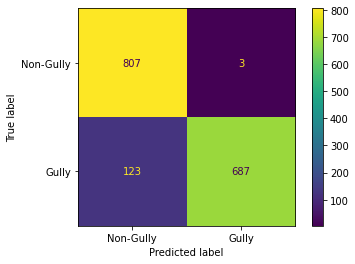

In [66]:
from sklearn import metrics
plt_labels = ["Non-Gully", "Gully"]
disp = metrics.ConfusionMatrixDisplay(cm, display_labels = plt_labels)
disp.plot()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(rounded_predictions, data["labels"]))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       765
           1       1.00      0.95      0.97       855

    accuracy                           0.97      1620
   macro avg       0.97      0.97      0.97      1620
weighted avg       0.97      0.97      0.97      1620



In [26]:
fp_data_points = np.where((data["labels"] == 0) & (rounded_predictions == 1))[0]
print(fp_data_points)

[ 815  829  831  879  910  920  922  941  973  975  988  994 1002 1051
 1103 1129 1139 1156 1167 1178 1188 1195 1211 1212 1234 1255 1274 1289
 1311 1313 1356 1377 1393 1413 1420 1432 1433 1453 1464 1495 1497 1504
 1507 1521 1566]


In [ ]:
with Image.open("")

In [33]:
print(len(fp_data_points))
print(len(data['labels']))
print(len(rounded_predictions))

45
1620
1620


In [34]:
img = Image.fromarray(data['features'][988])
img.show()